<h1>Calculating CWUBC</h1>
Jan 2016 <br/>

Given JSON summaries of projects, calculate Cumulative Weighted Unique Block Count (CWUBC) of projects

See Proposal, Page 4: http://benjixie.com/meng_proposal.pdf

REQUIRED: ai2summarizer.py (https://github.com/bxie/ai2_summarizer)

See also: Trajectory.ipynb

CWUBC Steps: <br/>
<ol>
    <li> <strike> parse directory and load JSON from directory </strike> </li>
    <li> <strike>calcualte T_all matrix (see proposal) </strike></li>
    <li> calculate block weighting </li>
</ol>

POPPS Steps: <br/>
<ol>
    <li><strike>Determine blocks corresponding to each programming skill</strike></li>
    <li><strike>Calculate POPPS matrix</strike></li>
</ol>

Clustering:
<ol>
    <li><strike>Separate users based on CWUBC</strike></li>
    <li><strike>Plot POPPS of each group</strike></li>
    <li><strike>Run K-Means clustering on CWUBC trajectory matrix</strike></li>
    <li><strike>Plot POPPS of each cluster</strike></li>    
</ol>

CSP Principles Trajectory:
1. Isolate CSP Blocks
1. Trajectory of CSP Blocks (freq, not binary)

Other:
<ul>
    <li><strike>Analyze slope of CWUBC</strike></li>
    <li>PCA</li>
    <li>Categorize Clusters (elbow)</li>
    <li>Prior Knowledge: Cluster based only on first n projects</li>
</ul>

In [39]:
import os
import os.path
import re
import json
import csv
import pickle
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick

#making plots look pretty
%matplotlib inline
matplotlib.style.use('ggplot')
pd.options.display.mpl_style = 'default'

from collections import Counter
from sklearn.cluster import KMeans

# ROOT_DIR = "/Users/bxie/Documents/ai2_users_random_small/"
ROOT_DIR = "/Users/bxie/Documents/ai2_users_random/"
NB_DIR = "/Users/bxie/programming/ai2_user_trajectory/data/"
REGEX_ROOT_IGNORE = 'python|\.|README'
REGEX_SUMMARY = 'summary\.json'
SUMMARY_SUFFIX = "_summary.json"
USER_ID_RAND = "000317"
PROJ_ID_RAND = "4673362639978496"

In [2]:
"""
code to get blocks
"""

"""
return dictionary of (user ids, num projects) 
for users w/ at least min_num_projects
"""
def get_users(min_num_projects):
    #regex to ignore non-project files
    ignore = 'python|\.|README'
    regexp=re.compile(ignore) #use: regexp.search(fname)

    fnames = filter(lambda x: regexp.search(x) is None, os.listdir(ROOT_DIR))
    super_users = {}

    for fname in fnames:
        num_projects = len(get_all_projects(fname))
        if num_projects > min_num_projects:
            super_users[fname] = num_projects

    return super_users

"""
Given user_id (user directory name), return list of all project ids
"""
def get_all_projects(user_id):
    unfiltered_project_names = os.listdir("{}{}".format(ROOT_DIR, user_id))
    project_names = filter(lambda x: x.isdigit(), unfiltered_project_names)
    return project_names

"""
given user id and project id, return project summary (as dictionary)
"""
def get_summary(user_id, project_id):
    summary_dir = "{}{}/{}{}".format(ROOT_DIR, user_id, project_id, SUMMARY_SUFFIX)
    with open(summary_dir) as data_file:
        data = json.load(data_file)
    return data

"""
Given project_id (user directory name), return lists of all active blocks, orphaned blocks
"""
def get_blocks(summary):
    screen_names = filter(lambda x: x.find("*")<0, summary.keys())
    blocks_count = Counter({})
    orphan_count = Counter({})
    for sname in screen_names:
        #if has blocks
        if has_blocks(summary, sname):
            blocks_count += Counter(summary[sname]['Blocks']['Active Blocks']['Types'])
        if has_blocks(summary, sname, check_active=False):
            orphan_count += Counter(summary[sname]['Blocks']['Orphan Blocks']['Types'])
    return dict(blocks_count), dict(orphan_count)

"""
Given blocks dict, save to CSV
"""
def save_blocks_to_csv(blocks_dict, new_fname_path):
    writer = csv.writer(open("{}.csv".format(new_fname_path), 'wb'))
    for key, value in blocks_dict.items():
        writer.writerow([key, value])
    return True


""""""""""""""" Helper Functions """""""""""""""

"""
Given project summary(dict) and screen name(str) 
and designation of active (default) or orphan blocks,
return boolean to determine if screen has those blocks
"""
def has_blocks(summary, screen_name, check_active=True):
    block_name = 'Active Blocks' if check_active else 'Orphan Blocks'
    return type(summary[screen_name]['Blocks']) == dict and type(summary[screen_name]['Blocks'][block_name]) == dict

In [59]:
""" Get all types of blocks """

"""
get count of all blocks of projects (up to upper_bound # of projects) by users with at least n (threshold) projects
"""
def get_all_blocks(threshold=0, upper_bound=THRESHOLD, have_upper_bound=True):
    counter_active = Counter({})
    counter_orphan = Counter({})    
    
    for user_id in get_users(threshold):
        project_ids = get_all_projects(user_id)
        if have_upper_bound:
            project_ids = project_ids[:upper_bound] # only select first n projects as defined by upper_bound

        for project_id in project_ids:
#             print "{}, {}".format(user_id, project_id)
            active, orphan = get_blocks(get_summary(user_id, project_id))
            counter_active += Counter(active)
            counter_orphan += Counter(orphan)
    return dict(counter_active), dict(counter_orphan)

"""
get count of all blocks by users with at least n (threshold) projects
"""
def get_blocks_project_count(threshold=0):
    counter_active = Counter({})
    counter_orphan = Counter({})    
    
    for user_id in get_users(threshold):
        for project_id in get_all_projects(user_id):
#             print "{}, {}".format(user_id, project_id)
            active, orphan = get_blocks(get_summary(user_id, project_id))
            active = {val:1 for val in active} #1 per project
            orphan = {val:1 for val in orphan}
            counter_active += Counter(active)
            counter_orphan += Counter(orphan)
    return dict(counter_active), dict(counter_orphan)

"""
get list of all block types
"""
def get_all_block_types(active_blocks, orphan_blocks):
    return list(set(active_blocks.keys() + orphan_blocks.keys()))

"""
load pickled block types
"""
def load_block_types(fname):
    block_types = open(fname, 'rb')
    output = pickle.load(block_types)
    block_types.close()
    return output

"""
save pickled block types
"""
def save_block_types(block_types_list, fname):
    block_types = open(fname, 'wb')
    pickle.dump(block_types_list, block_types)
    block_types.close()

In [4]:
"""
Calculating trajectory matrix (CWUBC)
"""

# order of this is important
block_types_fname = 'jeff_types.pkl'
BLOCK_TYPES = load_block_types(NB_DIR+block_types_fname)
THRESHOLD = 20

def get_all_trajectories(threshold=THRESHOLD):
    user_ids = get_users(threshold)
    user_traj_vectors = [] #list of user trajectory vectors
    for uid in user_ids:
        V_u = get_trajectory(uid)
        user_traj_vectors.append(V_u)
    return np.vstack(user_traj_vectors)

# given a user_id, return trajectory as vector of # of blocks used at each project
# BXX TODO: Add weighting
def get_trajectory(user_id, threshold=THRESHOLD):
    P_b = get_binary_matrix(user_id, threshold)
    V_u = np.sum(P_b, axis=1)
    return V_u

"""
given user id, get cumulative binary matrix of users x blocks
"""
def get_binary_matrix(user_id, threshold=THRESHOLD):
    P_u = get_freq_matrix(user_id, threshold)
    # print P_u[:, BLOCK_TYPES.index('color_make_color')]
    P_c = np.cumsum(P_u, axis = 0)
    # print P_c[:, BLOCK_TYPES.index('color_make_color')]
    return P_c>0
    

# given user_id, return matrix of frequency of blocks of each project 
# output: n x d matrix where n=# of projects (THRESHOLD), d = # of block types
def get_freq_matrix(user_id, threshold=THRESHOLD):
    output = np.zeros((threshold, len(BLOCK_TYPES)))
    project_ids = get_all_projects(user_id)[:threshold] # getting first n projects from user
    for i in range(threshold):
        pid = project_ids[i]
        summary = get_summary(user_id, pid)
        blocks = get_blocks(summary)[0]
        for blk, count in blocks.items():
            output[i, BLOCK_TYPES.index(blk)] = count
    return output

#normalize traj_matrix by max (if by_max) or by sum
def normalize_trajectory(traj_matrix, by_max=True):
    if by_max:
        user_norm = traj_matrix[:,-1] #final UBC for each user
    else:
        user_norm = traj_matrix.sum(axis=1)
    output = traj_matrix.astype(float) / user_norm[:, np.newaxis]
    return np.nan_to_num(output) #NaN from divide by zero error

def difference_trajectory(traj_matrix):
    return np.diff(traj_matrix, axis=1)

In [5]:
"""
Calculating POPPS
To get block type, from browser console: bs = Blocklies['5066549580791808_Screen1']; bs.selected.type
"""


#mapping programming skill to block types
POPPS_MAP = {
    'cond': [
        'controls_if', #conditional
        'controls_choose'
       ], 
    'list': [
        'lists_create_with', #list
        'lists_create_with', 
        'lists_add_items', 
        'lists_is_in', 
        'lists_length', 
        'lists_is_empty', 
        'lists_pick_random_item', 
        'lists_position_in', 
        'lists_select_item', 
        'lists_insert_item', 
        'lists_replace_item', 
        'lists_remove_item', 
        'lists_append_list', 
        'lists_copy', 
        'lists_is_list', 
        'lists_to_csv_row', 
        'lists_to_csv_table', 
        'lists_from_csv_row', 
        'lists_from_csv_table', 
        'lists_lookup_in_pairs'
       ], 
    'loop': [
        'controls_forEach', #loop
        'controls_forRange',
        'controls_while'
       ], 
    'logic': [
        'logic_negate', #operator
        'logic_or', 
        'logic_boolean', 
        'logic_false', 
        'logic_operation', 
        'logic_compare'
       ], 
    'var': [
        'lexical_variable_set', 
        'lexical_variable_get', 
        'local_declaration_expression', 
        'local_declaration_statement'], #variable
    'proc': [
        'procedures_defnoreturn', #procedure
        'procedures_callreturn', 
        'procedures_defreturn', 
        'procedures_callnoreturn'
       ],
    'proc_def': [
        'procedures_defnoreturn', #procedure
        'procedures_defreturn', 
       ],
    }

# flat list of all CC blocks (formerly known as POPPS blocks)
POPPS_ALL_BLOCKS = []


"""
given binary matrix to show POPPS, 
return vector for average proportion of users who have not learned skill by project i
"""
def get_average_survival(popps_matrix):
    return np.average(popps_matrix, axis=0)


"""
given specific programming skill (string) from POPPS_MAP.keys(),
optional list of user ids (select_users),
and optional threshold for min number of projects users must have
return binary matrix to show POPPS (row: user, column: 1 if used skill by that project)
"""
def get_popps_all_users(prog_skill, select_users=[], threshold=THRESHOLD, block_types=BLOCK_TYPES):
    user_ids = get_users(threshold) if len(select_users)==0 else select_users
    user_popps_vectors = [] #list of user trajectory vectors
    for uid in user_ids:
        P_b = get_specific_popps_binary(uid, prog_skill, threshold, block_types)
        user_popps_vectors.append(P_b)
    return np.vstack(user_popps_vectors)

"""
given user id (string),
specific programming skill (string) from POPPS_MAP.keys(),
optional thershold for number of projects to analyze,
and optional block types matrix (block_types_matrix),
return binary matrix for all POPPS that is 1 if user has skill by project i
"""
def get_specific_popps_binary(user_id, prog_skill, threshold=THRESHOLD, block_types= BLOCK_TYPES):
    if prog_skill not in POPPS_MAP:
        raise Exception("{} not in POPPS_MAP. Select from {}".format(prog_skill, POPPS_MAP.keys()))
    popps_binary = np.zeros([1, threshold])
    popps_binary[:] = 1
    P_b = get_binary_matrix(user_id, threshold)
    block_inds = get_block_indices(POPPS_MAP[prog_skill], block_types)
    found_proj_ind = np.argwhere(P_b[:,block_inds]==True) #locations in P_b that show block in project
    if len(found_proj_ind):
        #get first project that contains a block pertaining to prog_skill
        first_proj_ind = np.min(np.argwhere(P_b[:,block_inds]==True)[:,0])
        popps_binary[0, first_proj_ind:] = 0
    return popps_binary
    
"""
given user id (int as string), 
optional thershold for number of projects to analyze,
and optional block types matrix (block_types_matrix),
return binary matrix for all POPPS that is 1 if user has skill by project i
"""
def get_all_popps_binary(user_id, threshold=THRESHOLD, block_types= BLOCK_TYPES):
    num_popps = len(POPPS_MAP)
    popps_binary = np.zeros([num_popps, threshold])
    popps_binary[:,:] = 1
    for i in range(num_popps):
        prog_skill = POPPS_MAP.keys()[i]
        if prog_skill not in POPPS_MAP:
            raise Exception("{} not in POPPS_MAP. Select from {}".format(prog_skill, POPPS_MAP.keys()))
        P_b = get_binary_matrix(user_id, threshold)
        block_inds = get_block_indices(POPPS_MAP[prog_skill], block_types)
        found_proj_ind = np.argwhere(P_b[:,block_inds]==True) #locations in P_b that show block in project
        if len(found_proj_ind):
            #get first project that contains a block pertaining to prog_skill
            first_proj_ind = np.min(np.argwhere(P_b[:,block_inds]==True)[:,0]) 
            popps_binary[i, first_proj_ind:] = 0
    return popps_binary
    
    
""" HELPER FUNCTIONS """

"""
Given list of block types to identify (selected_blocks)
and optional blocks types matrix (block_types) 
return list of indices in matrix for given types
"""
def get_block_indices(selected_blocks, block_types = BLOCK_TYPES):
    indices = []
    for blk_type in selected_blocks:
        indices.append(block_types.index(unicode(blk_type)))
    return list(set(indices))

for key in POPPS_MAP.keys():
    POPPS_ALL_BLOCKS += POPPS_MAP[key]

POPPS_ALL_BLOCKS_INDS = get_block_indices(POPPS_ALL_BLOCKS)
OTHER_BLOCKS_INDS = list(set(range(0,len(BLOCK_TYPES))) - set(POPPS_ALL_BLOCKS_INDS))

#ensure disjoint sets
len(BLOCK_TYPES) == len(POPPS_ALL_BLOCKS_INDS) + len(OTHER_BLOCKS_INDS)

True

In [38]:
"""
isolating CC blocks
"""

# get user_id
# return 1D array (vector) of cumulative trajectory of 
def get_cc_trajectory(user_id, block_inds=POPPS_ALL_BLOCKS_INDS, threshold=THRESHOLD):
    mat_f = get_binary_matrix(user_id)
    mat_f = mat_f[: , block_inds] #select only relevant blocks
    mat_f = np.sum(mat_f, axis=1)
    return mat_f

def get_cc_trajectory_repeats(user_id, block_inds=POPPS_ALL_BLOCKS_INDS, threshold=THRESHOLD):
    mat_f = get_freq_matrix(user_id)
    mat_f[mat_f>0] = 1 #binary matrix
    mat_f = mat_f[: , block_inds] #select only relevant blocks
    mat_f = np.cumsum(mat_f, axis=0)
    mat_f = np.sum(mat_f, axis=1)
    return mat_f

def get_all_cc_trajectories(block_inds=POPPS_ALL_BLOCKS_INDS, threshold=THRESHOLD):
    user_ids = get_users(threshold)
    user_traj_vectors = [] #list of user trajectory vectors
    for uid in user_ids:
        V_u = get_cc_trajectory(uid, block_inds=block_inds)
        user_traj_vectors.append(V_u)
    return np.vstack(user_traj_vectors)

In [14]:
"""
get all block types
shouldn't need to run if have saved pickled block types (blocks_type_fname)
"""

# active, orphan = get_all_blocks(0)
# all_types = get_all_block_types(active, orphan)# flat list of all CC blocks (formerly known as POPPS blocks)
all_cc_blocks = []

for key in POPPS_MAP.keys():
    all_cc_blocks += POPPS_MAP[key]

cc_block_inds = get_block_indices(all_cc_blocks)


# save block types
# save_blocks_to_csv(active, NB_DIR + "jeff_0_active")
# save_blocks_to_csv(orphan, NB_DIR + "jeff_0_orphan")
# save_block_types(all_types, NB_DIR + "jeff_types.pkl")
# print 'all saved!'

In [8]:
#get trajectories
T_all = get_all_trajectories()

#NB: associating blocks and block types now less trivial
T_all_cc = get_all_cc_trajectories(block_inds=POPPS_ALL_BLOCKS_INDS)
T_all_not = get_all_cc_trajectories(block_inds=OTHER_BLOCKS_INDS)
# save_block_types(T_all, 'traj.pkl')
print 'done'
# np.shape(np.average(T_all, axis=0))

done


## Block Frequency Analysis

In [60]:
#blocks counts
#THIS TAKES TIME
active_total, orphan_total = get_all_blocks(20) # total # of blocks used in all projects
active_proj, orphan_proj = get_blocks_project_count(20) # num of projects to have specific block.

In [129]:
c = Counter(active_proj)
# filter(lambda k: k in all_cc_blocks, active.keys())
cc_dict = {k: active_proj[k] for k in all_cc_blocks}

cc_count = Counter(cc_dict)
# print cc_count.most_common(10)
# print
cc_count_sorted = cc_count.most_common()

cc_count_sorted

btypes = []
counts = []

for key, count in cc_count_sorted:
    btypes.append(key)
    counts.append(count)
    print "{}\t{}".format(key, count)

lexical_variable_get	3397
controls_if	2647
lexical_variable_set	2388
logic_boolean	1604
procedures_defnoreturn	1426
procedures_callnoreturn	1379
lists_create_with	1333
logic_false	1105
logic_compare	921
lists_select_item	770
lists_add_items	545
logic_operation	418
logic_negate	411
lists_length	385
procedures_defreturn	335
controls_forEach	329
procedures_callreturn	306
controls_while	304
controls_forRange	266
logic_or	224
controls_choose	207
local_declaration_statement	182
lists_pick_random_item	128
lists_is_in	126
lists_is_empty	116
lists_replace_item	107
lists_remove_item	83
local_declaration_expression	73
lists_position_in	64
lists_is_list	59
lists_copy	48
lists_from_csv_row	38
lists_insert_item	27
lists_lookup_in_pairs	25
lists_from_csv_table	21
lists_to_csv_row	20
lists_to_csv_table	17
lists_append_list	12


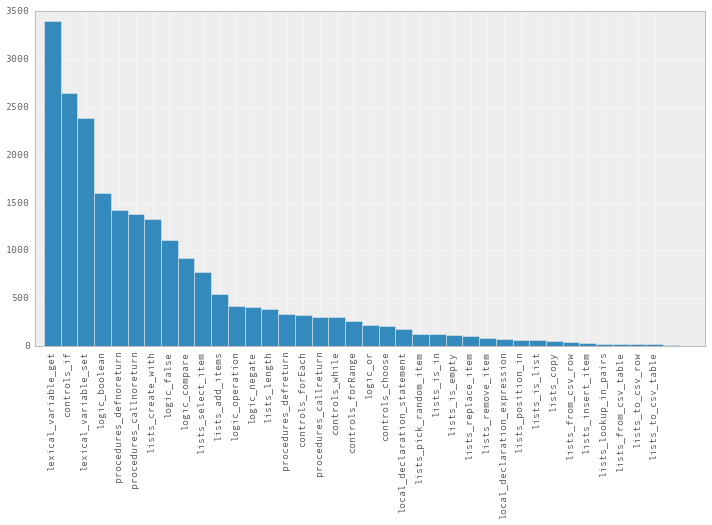

In [126]:
index = np.arange(len(counts))


#Histogram of CC block frequency
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(0, len(counts))+0.5, counts, width=1)
fig.set_size_inches(12,6)
plt.xticks(index, ['']+btypes, rotation='vertical')
plt.show()

In [ ]:
#Plot of freq ofCC block types in each project 


In [9]:
"""
plotting
""" 

"""
Given list of trajectory matrices (list of ndarray)
and text describing grouping methods
return plot of average trajectory of each matrix in list
"""
def plot_cwubc_avg(traj_matrix_list, add_zero=True, grouped_by_text=""):
    plt.figure(figsize=(12,8))
    plt.xlabel('Project Number')
    plt.ylabel('Number of Unique Blocks')

    plt.title("Avg Distinct Block Count for Users Grouped By {}".format(grouped_by_text))

    my_legend = []
    
    for i in range(len(traj_matrix_list)):
        t_mat = traj_matrix_list[i]
        num_users = np.shape(t_mat)[0]
        if add_zero:
            t_mat = np.insert(t_mat, 0, 0, axis=1) #0 added in beginning for plot
        T_avg = np.average(t_mat, axis=0) #avg of each column/at each project
        plt.plot(T_avg, linewidth=5)
        my_legend.append("{} ({} users)".format(i, num_users))

    plt.legend(my_legend)

"""
Given trajectory matrix (ndarray),
plot trajectory of all users (rows) separately
"""
def plot_cwubc_all_users(traj_matrix, add_zero=True):
    plt.figure(figsize=(12,8))
    num_users = np.shape(traj_matrix)[0]
    if add_zero:
        T_all_plot = np.insert(traj_matrix, 0, 0, axis=1) #0 added in beginning for plot
    else:
        T_all_plot = traj_matrix
    # plt.plot(T_all_mean, linestyle='dotted', linewidth=5)
    plt.xlabel('Project Number')
    plt.ylabel('Number of Unique Blocks')

    plt.title("Cummulative Number of Blocks Used by AI User")
    for i in range(T_all_plot.shape[0]):
        plt.plot(T_all_plot[i,:])
    #TODO: figuer out return

""" HELPER FUNCTIONS """

"""
Given number of groups, return list of human-readable strings
to be element of POPPS plot that splits 100% into num_groups groups
ex: num_groups = 4 => ['<25%','25-50%','50-75%','>75%']
"""
def create_legend(num_groups):
    vals = range(0,101,100/num_groups)
    output = []
    output.append("<{}%".format(vals[1]))
    for i in range(1,len(vals)-2):
        output.append("{}-{}%".format(vals[i], vals[i+1]))
    output.append(">{}%".format(vals[-2]))
    return output

# given 1D numpy array, return same array w/ 0.0
# added to first term
def add_zero(vector):
    return np.insert(0.0, 1, vector)

In [10]:
"""
Grouping Users by final CWUBC (AKA dumb clustering)
"""

"""
given CWUBC trajectory matrix (traj_matrix, ndarray)
and number of desired groups (n, as int),
split traj_matrix according to final CWUBC.
return list of n matrices representing traj_matrix split n ways and
list of lists of indices in matrix that correspond to each split
"""
def split_by_end_cwubc(traj_matrix, n):
    end_cwubc = traj_matrix[:,-1]
    thresholds = np.percentile(traj_matrix[:,-1], range(0,101,100/n)) #get thresholds for spliting n ways
    
#     indices = []
    output = []
    indices = []
    for i in range(len(thresholds)-1):
#         indices.append(np.argwhere(np.all([end_cwubc>=thresholds[i], end_cwubc<thresholds[i+1]], axis=0)))
        inds = np.argwhere(np.all([end_cwubc>=thresholds[i], end_cwubc<thresholds[i+1]], axis=0)).flatten()
        indices.append(inds)
        output.append(traj_matrix[inds])

    return output, indices

In [12]:
### DEPRECATED ###
#Splitting users by CWUBC and comparing POPPS

"""
given list of lists of indicies (list of int),
list of skills (strings corresponding to POPPS_MAP.keys()),
plot POPPS survival curve
"""
def plot_popps(grouped_inds, grouped_by_text="<something>", skills=POPPS_MAP.keys()):
    for skill in skills:
        user_ids = []
        popps = []
        all_user_ids = np.array(get_users(THRESHOLD).keys())
        legend = []
        for i in range(len(grouped_inds)):
            indices = grouped_inds[i]
            temp_uids = all_user_ids[indices]
            user_ids.append(temp_uids)
            p = get_popps_all_users(skill, temp_uids)
            p_avg = get_average_survival(p)
            p_avg = np.insert(p_avg, 0, 1.0)
            popps.append(p_avg)
            legend.append("{} ({} users)".format(i, len(temp_uids)))
        plt.figure(figsize=(12,8))
        plt.title("Surirval Curve of Users Grouped by {}: {}".format(grouped_by_text.title(), skill.title()))
        plt.xlabel("Project")
        plt.ylabel("Proportion of Users Who Have Never Used {}".format(skill.title()))
        for p_avg in popps:
            plt.plot(p_avg, linewidth=5)
        plt.legend(legend)
    
    
# n = 3
# mats, inds = split_by_end_cwubc(T_all, n)

# for skill in POPPS_MAP.keys():
#     user_ids = []
#     popps = []
#     all_user_ids = np.array(get_users(THRESHOLD).keys())
#     for i in range(len(inds)):
#         indices = inds[i]
#         temp_uids = all_user_ids[indices]
#         user_ids.append(temp_uids)
#         p = get_popps_all_users(skill, temp_uids)
#         p_avg = get_average_survival(p)
#         p_avg = np.insert(p_avg, 0, 1.0)
#         popps.append(p_avg)
#     plt.figure(figsize=(12,8))
#     plt.title("Surirval Curve of Users Grouped by CWUBC: {}".format(skill.title()))
#     plt.xlabel("Project")
#     plt.ylabel("Proportion of Users Who Have Never Used Concept")
#     for p_avg in popps:
#         plt.plot(p_avg, linewidth=5)
#     plt.legend(create_legend(n))
    
# plot_cwubc_avg(mats)
# plot_cwubc_all_users(mats[3])

### Trajectory Comparison: All Blocks vs Comp. Concepts

TODO:
- function to plot these (input: trajectory list, title, ylabel, legend)
- see if learning rate is exponential decay [See SO Answer](http://stackoverflow.com/questions/3938042/fitting-exponential-decay-with-no-initial-guessing)

In [13]:
# plot_trajectory(traj_mat_list, title="", ylabel="", percent=False, legend_loc=2)
def plot_trajectory(traj_mat_list, title="Avg Distinct Block Count", 
                    ylabel="Cum. Number of Distinct Blocks", 
                    legend = ['Comp. Concepts Blocks', 'Non-CC Blocks'], legend_loc=2, percent=False):

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    plt.xlabel('Project Number', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=24)
    my_legend = legend

    for i in range(len(traj_mat_list)):
        t_mat = traj_mat_list[i]
        if percent:
            t_mat = t_mat * 100 #for percent
        num_users = np.shape(t_mat)[0]
        t_mat = np.insert(t_mat, 0, 0, axis=1) #0 added in beginning for plot
        T_avg = np.average(t_mat, axis=0) #avg of each column/at each project
        plt.plot(T_avg, linewidth=5)
        my_legend.append("{} ({} users)".format(i, num_users))

    plt.legend(my_legend, loc=legend_loc, fontsize=18)
    if percent:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
        
    return fig, ax

(<matplotlib.figure.Figure at 0x111696b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1116fa4d0>)

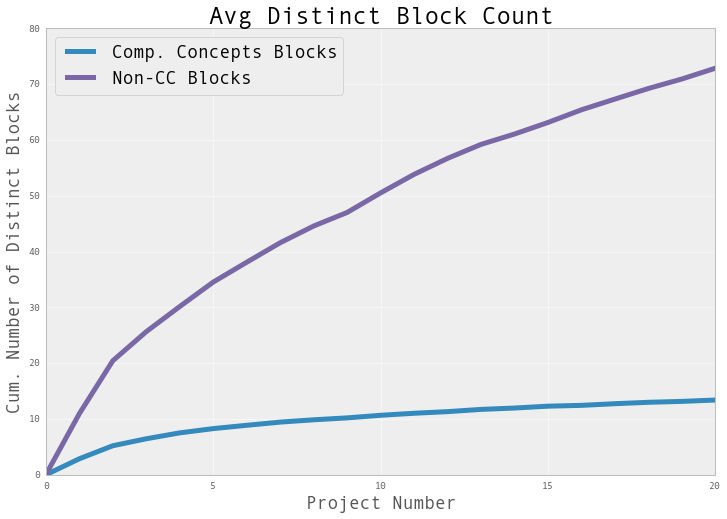

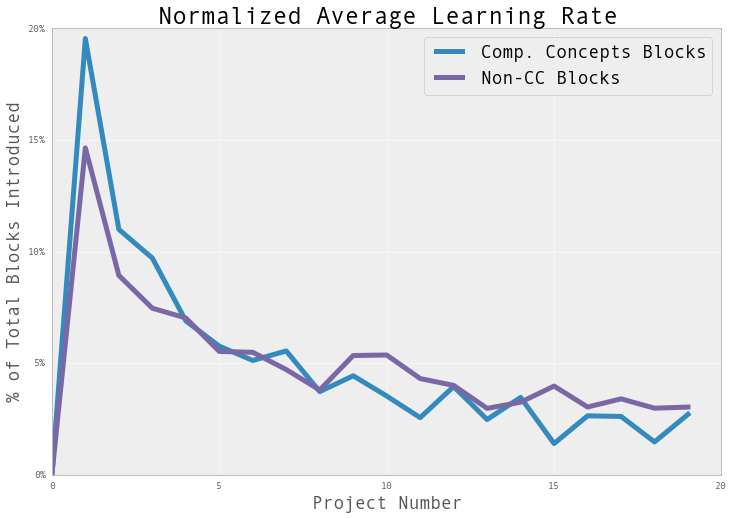

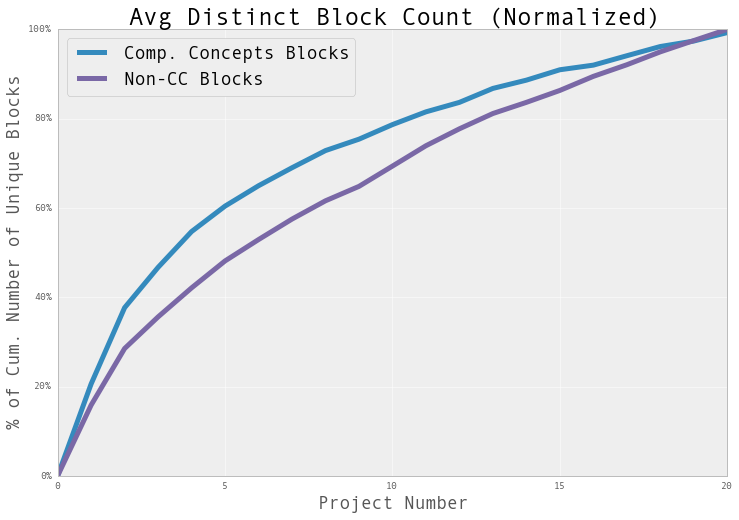

In [14]:
"""
Plotting UBC of all blocks vs CT blocks
"""
mats, inds = split_by_end_cwubc(T_all, 1)
mats_not, inds_not = split_by_end_cwubc(T_all_not, 1)
mats_cc, inds_cc = split_by_end_cwubc(T_all_cc, 1)

both_mats = [mats_cc[0], mats_not[0]]

#Avg Block Count
plot_trajectory(both_mats)


#Normalized Learning Rate
mats_delta = [normalize_trajectory(difference_trajectory(mats_cc[0]), by_max=False),
              normalize_trajectory(difference_trajectory(mats_not[0]), by_max=False)]

plot_trajectory(mats_delta, title="Normalized Average Learning Rate", ylabel="% of Total Blocks Introduced", 
                percent=True, legend_loc=1)


#Normalized Block Count
mats_norm = [normalize_trajectory(mats_cc[0]), normalize_trajectory(mats_not[0])]
# both_mats_norm = [normalize_trajectory(mats_cc[0])]

plot_trajectory(mats_norm, title="Avg Distinct Block Count (Normalized)", 
                ylabel="% of Cum. Number of Unique Blocks", percent=True, legend_loc=2)

In [199]:
"""
Clustering
"""

"""
given trajectory matrix (n x d where d is num of projects)
and optional number of clusters,
return list of trajectory matrices for each cluster of users
"""
def k_means(traj_matrix, num_clusters = 3):
    estimator = KMeans(n_clusters=num_clusters)
    estimator.fit(traj_matrix)
    predict = estimator.predict(traj_matrix)
    cluster_ind = [] #list of lists of ind in given cluster
    T_cluster = []
    for i in range(num_clusters):
        cluster_ind.append(np.argwhere(predict==i).flatten())
        T_cluster.append(traj_matrix[cluster_ind[i]])
        print "{} has {} users".format(i, len(cluster_ind[i]))
    return T_cluster, cluster_ind


In [16]:
T_cluster = k_means(T_all, 3)[0]
print
delta = np.diff(T_all, axis=1)
T_diff_ind = k_means(delta, 3)[1]
T_diff = []
T_diff_not = []
T_diff_cc = []
for i in range(3):
    T_diff.append(T_all[T_diff_ind[i]])
    T_diff_not.append(T_all_not[T_diff_ind[i]])
    T_diff_cc.append(T_all_cc[T_diff_ind[i]])

NameError: name 'k_means' is not defined

In [15]:
mats, inds = split_by_end_cwubc(T_all, 3)
# plot_cwubc_avg(mats, 'end block count')
# plot_cwubc_avg(T_cluster, 'kmeans clustering')
plot_cwubc_avg(T_diff, grouped_by_text='kmeans diff')

traj_mat_list_not = T_diff_not
traj_mat_list_cc = T_diff_cc
for i in range(len(traj_mat_list_not)):
    traj_both = [normalize_trajectory(traj_mat_list_cc[i]), normalize_trajectory(traj_mat_list_not[i])]
    plot_trajectory(traj_both, title="Avg Distinct Block Count (Normalized), Cluster {}".format(i), 
                    ylabel="% of Cum. Number of Unique Blocks", percent=True, legend_loc=4) 

NameError: name 'T_diff' is not defined

Grouping based on slope of trajectory, K-Means

Smallest Cluster (~10 users) has sharp spike in UBC from 1st to 2nd project but sample too small to determine if relevant.

In [198]:
# grouped_inds = k_means(T_all, 3)[1]
g_text = "KMeans diff"
delta = np.diff(T_all, axis=1)
grouped_inds = k_means(delta, 3)[1]
T_diff = []
for i in range(3):
    T_diff.append(T_all[grouped_inds[i]])
plot_cwubc_avg(T_diff, g_text)
# plot_popps(grouped_inds, grouped_by_text=g_text)


NameError: name 'k_means' is not defined

Attempting Fixed Effect Models

x: UBC
y: # of projects using procedures (# of procedures

In [131]:
"""
getting ind where project uses procedures
"""

"""
given user_id (string) and prog_skill (string that is in POPPS_MAP.keys()),
return vector of length threshold that is 1 if prog_skill is used in that project, 0 else
"""
# def get_specific_popps_location(user_id, prog_skill, threshold=THRESHOLD, block_types= BLOCK_TYPES):
#     if prog_skill not in POPPS_MAP:
#         raise Exception("{} not in POPPS_MAP. Select from {}".format(prog_skill, POPPS_MAP.keys()))
#     popps_count = np.zeros(threshold)

#     P_f = get_freq_matrix(user_id, threshold)
#     block_inds = get_block_indices(POPPS_MAP[prog_skill], block_types)
#     found_proj_ind = np.unique(np.argwhere(P_f[:,block_inds]>0)[:,0]) #project inds in P_f that have prog skill in project
#     if len(found_proj_ind):
#         popps_count[found_proj_ind] = 1
#     return popps_count

"""
given user_id (string) and prog_skill (string that is in POPPS_MAP.keys()),
optional binary (boolean) that returns binary/boolean vector instead of true counts if true,
return vector of length threshold that shows number of blocks related to prog_skill used in project
"""
def get_specific_popps_counts(user_id, prog_skill, binary=False, threshold=THRESHOLD, block_types= BLOCK_TYPES):
    if prog_skill not in POPPS_MAP:
        raise Exception("{} not in POPPS_MAP. Select from {}".format(prog_skill, POPPS_MAP.keys()))
    popps_count = np.zeros(threshold)

    P_f = get_freq_matrix(user_id, threshold)
    block_inds = get_block_indices(POPPS_MAP[prog_skill], block_types)
    blk_count = P_f[:,block_inds][:,0] #num of prog skill blocks in each project
#     print blk_count
    if binary:
        return blk_count>0
    return blk_count


In [130]:
uid = '000317'
proj_inds = get_specific_popps_counts(uid, 'proc')
# num_proj = np.nonzero(proj_inds>0)[0].shape[0]
# num_proj
np.sum(proj_inds)

[ 0.  2.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.
  0.  0.]


9.0

In [150]:
#getting UBC and # of projects w/ procedure for each user
#end UBC
ubc = T_all[:,-1]
# print ubc

is_binary = True
data = np.zeros([len(ubc), 2])
data[:,0] = ubc

# print user_ids

user_ids = get_users(20)
for i in range(len(user_ids)):
    uid = user_ids.keys()[i]
    proj_inds = get_specific_popps_counts(uid, 'proc', binary=is_binary)
    if is_binary:
        count = np.nonzero(proj_inds>0)[0].shape[0]
    else:
        count = np.sum(proj_inds)
    data[i,1] = count
    

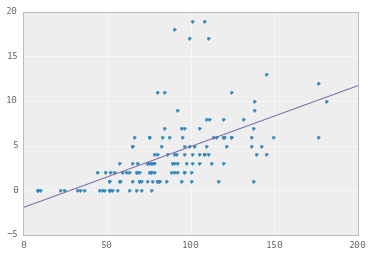

In [151]:
x = data[:,0]
y = data[:,1]
fit = np.polyfit(x,y,1)
p = np.poly1d(fit)


xp = np.linspace(0,200,1000)

_ = plt.plot(x, y, '.', xp, p(xp), '-')
# plt.scatter(x, y)


In [152]:
# calculating correlation
np.corrcoef(x,y)[0,1]

0.55629524021334065

In [27]:
pf = get_freq_matrix('000317', 20)
block_inds = get_block_indices(POPPS_MAP['proc'], BLOCK_TYPES)
found_proj_ind = np.argwhere(pf[:,block_inds]>0) #locations in P_b that show block in project
found_proj_ind

array([[ 1,  0],
       [ 1,  3],
       [ 2,  0],
       [ 2,  3],
       [12,  0],
       [12,  3]])

In [37]:
len(np.unique(found_proj_ind[:,0]))

3

In [43]:
x=np.zeros(10)
x[[2,4,6]]=2
x

array([ 0.,  0.,  2.,  0.,  2.,  0.,  2.,  0.,  0.,  0.])

In [30]:
pf[:,block_inds]

array([[ 0.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  4.],
       [ 3.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 4.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

## Computational Concepts Trajectory